In [1]:
import integration.rhs as rhs
import integration.gauss_legendre as gl
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.special as sp
import FourierSeries as fs
from scipy.integrate import solve_ivp

In [2]:
simManager = rhs.SimulationManager(r"D:\repos\superfluid-dynamics\CuSuperHelium\x64\Release\CuSuperHelium.dll")

In [3]:
import os


alpha_hammaker = 2.6e-24


N = 32
def rhs_func(t, y, L = 1e-6, depth = 15e-9):
        local_x = y[:N]
        local_ampl = y[N:2*N]
        local_pot = y[2*N:3*N]
        res, vx, vy, dphi = simManager.calculate_rhs_from_vectors(local_x, local_ampl, local_pot, L, 145, 0, depth)
        if res != 0:
            raise Exception("Error in calculation")
        return np.concatenate((vx, vy, dphi))

def mode(t, r, r0, R, omega, zeta, A, phase_space=0, phase_time=0):
        return A * np.cos(zeta * (r - r0) / R + phase_space) * np.cos(omega * t + phase_time)
def zeta(n):
        return sp.jn_zeros(1, n)
modes = 1
zetas = zeta(modes)
def c3(d):
        return np.sqrt(3 * alpha_hammaker / d**3)
def angular_freq(zeta, _c3, R):
    return zeta * _c3 / R

L = 1e-3
depth = 50e-9

def f(y, L):
    return rhs_func(0, y, L, depth)

def J(y, L):
    local_x = y[:N]
    local_ampl = y[N:2*N]
    local_pot = y[2*N:3*N]
    res, jacobian = simManager.calculate_jacobian(local_x, local_ampl, local_pot, L, 145, 0, depth)
    if jacobian is None or res != 0:
        raise Exception("Error in Jacobian calculation")
    return jacobian

r = np.array([2.0*np.pi/N*x for x in range(N)])
initial_amplitude = 0.001*depth
L0 = L / (2.0 * np.pi)
g = 3*2.6e-24 / depth**4
_t0 = np.sqrt(L0 / g)

speed = c3(depth)
omegas = angular_freq(zetas, speed, 2*np.pi)
phase_spaces = np.zeros_like(zetas)  # np.random.uniform(0, 0.1*np.pi, modes)

def gaussian(x, x0 = 0.75*np.pi, sigma=0.4):
        return np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))
def soliton_sech2(x, x0 = 0.75*np.pi, width=0.4):
        return 1.0 / np.cosh((x - x0) / width) ** 2

def bimodal(x, x0, x1, sigma1 = 0.4, sigma2 = 0.4, a1 = 1.0, a2 = 1.0):
    return a1 * gaussian(x, x0, sigma1) + a2 * soliton_sech2(x, x1, sigma2)



amplitude = []
# potential = []
# for i in range(modes):
#     m = lambda x: mode(0, x, np.pi, 2.0*np.pi, omegas[i], zetas[i], initial_amplitude / L0, 0, phase_spaces[i])
#     a0_ex, an_ex, bn_ex = fs.compute_fourier_series(lambda x: bimodal(x, 0.5*np.pi, 1.25*np.pi, 0.4, 0.4, initial_amplitude / L0, initial_amplitude / L0), 10) # fs.compute_fourier_series(lambda x: soliton_sech2(x, np.pi, 0.5), 12)
#     m_ampl = [fs.fourier_series(x, a0_ex, an_ex, bn_ex) for x in r]
#     amplitude.append(m_ampl)
#     # amplitude.append(np.cos((i + 1) * r) * initial_amplitude / L0)
#     # potential.append(np.sin((i + 1) * r) * initial_amplitude / L0)

# sum = np.sum(amplitude, axis=0)
# ampl = sum / np.max(np.abs(sum)) * (initial_amplitude / L0)

# pot = np.sum(potential, axis=0)
# pot = pot / np.max(np.abs(pot)) * (initial_amplitude / L0)
def setInitialY0(r, L, initial_amplitude):
    L0 = L / (2.0 * np.pi)
    pot = np.zeros_like(r)
    ampl = np.cos(r) * initial_amplitude / L0
    pot = initial_amplitude/L0 * np.sin(r)
    return np.concatenate((r, ampl, pot))

def saveSimulationFile(filename, T, Y, Y0, L, depth, t0, t1, initial_amplitude, g):
    with h5py.File(filename, "w") as file:
        file.create_dataset("T", data=T)
        file.create_dataset("Y", data=Y)
        # file.create_dataset("x0", data=r)
        file.create_dataset("Y0", data=Y0)
        # file.create_dataset("pot0", data=pot)
        file.attrs["depth"] = depth
        file.attrs["L"] = L
        file.attrs["N"] = N
        file.attrs["t0"] = t0
        file.attrs["t1"] = t1
        file.attrs["initial_amplitude"] = initial_amplitude
        file.attrs["g"] = g
def loadSimulationFile(filename):
    ## check that file exists first
    if not os.path.exists(filename):
         return None
    with h5py.File(filename, "r") as file:
        T = np.array(file["T"])
        Y = np.array(file["Y"])
        Y0 = np.array(file["Y0"])
        depth = file.attrs["depth"]
        L = file.attrs["L"]
        N = file.attrs["N"]
        t0 = file.attrs["t0"]
        t1 = file.attrs["t1"]
        initial_amplitude = file.attrs["initial_amplitude"]
        g = file.attrs["g"]
        return T, Y, Y0, L, depth, N, t0, t1, initial_amplitude, g
    

print(f"Reference Time is {_t0:.2e} s")

t0 = 0.0
t1 = 25 * 500
h = 3
print(f"Integrating from t={t0:.2e} to t={t1:.3f} (nondim) with step h={h} (nondim))")
print(f"c3 is {speed:.2e} m/s")

Reference Time is 1.13e-05 s
Integrating from t=0.00e+00 to t=12500.000 (nondim) with step h=3 (nondim))
c3 is 2.50e-01 m/s


In [4]:
plt.figure()
plt.plot(r, ampl, label="Initial Amplitude")

NameError: name 'ampl' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
res, Jac = simManager.calculate_jacobian(r, ampl, pot, L, 145, 0, depth)
eigvals = np.linalg.eigvals(Jac)
plt.figure()
plt.scatter(np.real(eigvals), np.imag(eigvals), label="Eigenvalues of Jacobian")

In [ ]:
# t0, t1, h = 0.0, 547, 0.5
# from tqdm import tqdm
max_wave_length = 1e-4
min_wave_length = 1e-6


waveNumbers = np.linspace(1e3, 200000, 20)
waveLengths = 1 / waveNumbers
periods = 250
h = 10

initial_amplitudes = np.linspace(1e-6 * depth, 1e-2 * depth, 20)
wl = waveLengths[5] # 2*np.pi / (1.89e5)

# for wl in waveLengths[5:]: # next one to start with 1.87e-05
for amplitude in initial_amplitudes[1:]:
    y0 = setInitialY0(r, wl, amplitude)
    t1 = wl / speed * periods
    L0 = wl / (2.0 * np.pi)
    _t0 = np.sqrt(L0 / g)
    h = 0.005 * wl / speed / _t0
    print(f"Simulating wave length {wl:.2e} m for time {t1:.2e} s, equivalent to {t1/_t0:.2e} nondim time, with a max step size of {h:.2f} nondim. Initial amplitude {amplitude:.2e} m")
    simProperties = rhs.CSimulationProperties(
        L = wl,
        depth = depth,
        rho = 145,
        kappa = 0,
    )
    gaussLegendreOptions = rhs.CGaussLegendreOptions(
        t0 = 0,
        t1 = t1 / _t0,
        stepSize = h,
        newtonTolerance = 1e-10,
        maxNewtonIterations = 12,
        allowSimplifiedFallback = True,
        returnTrajectory = True,
        armijo_c = 1e-4,
        backtrack = 0.5,
        minAlpha = 1e-6,
        maxStepsHalves = 20
    )

    if os.path.exists(f"data/fixed/simulation_ia_{amplitude:.2e}m.h5"):
        T, Y, Y0, L_loaded, depth_loaded, N_loaded, t0_loaded, t1_loaded, initial_amplitude_loaded, g_loaded = loadSimulationFile(f"data/fixed/simulation_ia_{amplitude:.2e}m.h5")
        if(t1 / _t0 <= t1_loaded):
            print(f"  Simulation already exists with sufficient time {t1_loaded:.2e} s, skipping.")
            continue
        else:
            print(f"  Simulation exists but insufficient time {t1_loaded:.2e} s, extending to {t1:.2e} s.")
            gaussLegendreOptions.t0 = t1_loaded
            res, T_new, Y_new = simManager.integrate(Y[-1, :], simProperties, gaussLegendreOptions)
            if res != 0:
                print(f"  Error during integration extension.")
                continue
            # T_new, Y_new = gl.integrate_gl2(lambda y: f(y, wl),  lambda y: J(y, wl), Y[-1, :], t1_loaded, t1 / _t0, h, show_progress = True, max_step_halves=20)
            Tcon = np.concatenate((T, T_new))
            Ycon = np.concatenate((Y, Y_new))
            saveSimulationFile(f"data/fixed/simulation_ia_{amplitude:.2e}m.h5", Tcon, Ycon, y0, wl, depth, t0, t1 / _t0, amplitude, g)
    else:
        res, T, Y = simManager.integrate(y0, simProperties, gaussLegendreOptions)
        if res != 0:
            print(f"  Error during integration.")
            continue
        # T, Y = gl.integrate_gl2(lambda y: f(y, wl),  lambda y: J(y, wl), y0, t0, t1 / _t0, h, show_progress = True, max_step_halves=20)
        saveSimulationFile(f"data/fixed/simulation_ia_{amplitude:.2e}m.h5", T, Y, y0, wl, depth, t0, t1 / _t0, amplitude, g)
    

# result = solve_ivp(lambda t, y: f(y), (t0, t1), y0, method='RK45')

Simulating wave length 1.87e-05 m for time 1.88e-02 s, equivalent to 1.21e+04 nondim time, with a max step size of 0.24 nondim. Initial amplitude 2.64e-11 m
  Simulation exists but insufficient time 4.85e+03 s, extending to 1.88e-02 s.


Integrating: 100%|██████████| 7278.703255474015/7278.703255474015 [49:21<00:00,  2.46t-units/s]   


Simulating wave length 1.87e-05 m for time 1.88e-02 s, equivalent to 1.21e+04 nondim time, with a max step size of 0.24 nondim. Initial amplitude 5.27e-11 m
  Simulation exists but insufficient time 4.85e+03 s, extending to 1.88e-02 s.


Integrating: 100%|██████████| 7278.703255474015/7278.703255474015 [52:26<00:00,  2.31t-units/s]   


Simulating wave length 1.87e-05 m for time 1.88e-02 s, equivalent to 1.21e+04 nondim time, with a max step size of 0.24 nondim. Initial amplitude 7.90e-11 m
  Simulation exists but insufficient time 4.85e+03 s, extending to 1.88e-02 s.


Integrating: 100%|██████████| 7278.703255474015/7278.703255474015 [53:55<00:00,  2.25t-units/s]   


Simulating wave length 1.87e-05 m for time 1.88e-02 s, equivalent to 1.21e+04 nondim time, with a max step size of 0.24 nondim. Initial amplitude 1.05e-10 m
  Simulation exists but insufficient time 4.85e+03 s, extending to 1.88e-02 s.


Integrating: 100%|██████████| 7278.703255474015/7278.703255474015 [59:10<00:00,  2.05t-units/s]   


Simulating wave length 1.87e-05 m for time 1.88e-02 s, equivalent to 1.21e+04 nondim time, with a max step size of 0.24 nondim. Initial amplitude 1.32e-10 m
  Simulation exists but insufficient time 4.85e+03 s, extending to 1.88e-02 s.


Integrating: 100%|██████████| 7278.703255474015/7278.703255474015 [1:00:52<00:00,  1.99t-units/s] 


Simulating wave length 1.87e-05 m for time 1.88e-02 s, equivalent to 1.21e+04 nondim time, with a max step size of 0.24 nondim. Initial amplitude 1.58e-10 m
  Simulation exists but insufficient time 4.85e+03 s, extending to 1.88e-02 s.


Integrating: 100%|██████████| 7278.703255474015/7278.703255474015 [1:05:18<00:00,  1.86t-units/s] 


Simulating wave length 1.87e-05 m for time 1.88e-02 s, equivalent to 1.21e+04 nondim time, with a max step size of 0.24 nondim. Initial amplitude 1.84e-10 m
  Simulation exists but insufficient time 4.85e+03 s, extending to 1.88e-02 s.


Integrating: 100%|██████████| 7278.703255474015/7278.703255474015 [1:09:35<00:00,  1.74t-units/s] 


Simulating wave length 1.87e-05 m for time 1.88e-02 s, equivalent to 1.21e+04 nondim time, with a max step size of 0.24 nondim. Initial amplitude 2.11e-10 m
  Simulation exists but insufficient time 4.85e+03 s, extending to 1.88e-02 s.


Integrating: 100%|██████████| 7278.703255474015/7278.703255474015 [1:15:25<00:00,  1.61t-units/s] 


Simulating wave length 1.87e-05 m for time 1.88e-02 s, equivalent to 1.21e+04 nondim time, with a max step size of 0.24 nondim. Initial amplitude 2.37e-10 m
  Simulation exists but insufficient time 4.85e+03 s, extending to 1.88e-02 s.


Integrating: 100%|██████████| 7278.703255474015/7278.703255474015 [1:18:31<00:00,  1.54t-units/s] 


Simulating wave length 1.87e-05 m for time 1.88e-02 s, equivalent to 1.21e+04 nondim time, with a max step size of 0.24 nondim. Initial amplitude 2.63e-10 m
  Simulation exists but insufficient time 4.85e+03 s, extending to 1.88e-02 s.


Integrating: 100%|██████████| 7278.703255474015/7278.703255474015 [1:41:08<00:00,  1.20t-units/s] 


Simulating wave length 1.87e-05 m for time 1.88e-02 s, equivalent to 1.21e+04 nondim time, with a max step size of 0.24 nondim. Initial amplitude 2.89e-10 m


Integrating: 100%|██████████| 12131.17209245669/12131.17209245669 [4:57:30<00:00,  1.47s/t-units]   


Simulating wave length 1.87e-05 m for time 1.88e-02 s, equivalent to 1.21e+04 nondim time, with a max step size of 0.24 nondim. Initial amplitude 3.16e-10 m


Integrating: 100%|██████████| 12131.17209245669/12131.17209245669 [6:15:43<00:00,  1.86s/t-units]   


Simulating wave length 1.87e-05 m for time 1.88e-02 s, equivalent to 1.21e+04 nondim time, with a max step size of 0.24 nondim. Initial amplitude 3.42e-10 m


Integrating: 100%|██████████| 12131.17209245669/12131.17209245669 [6:23:33<00:00,  1.90s/t-units]   


Simulating wave length 1.87e-05 m for time 1.88e-02 s, equivalent to 1.21e+04 nondim time, with a max step size of 0.24 nondim. Initial amplitude 3.68e-10 m


Integrating: 100%|██████████| 12131.17209245669/12131.17209245669 [7:16:01<00:00,  2.16s/t-units]   


Simulating wave length 1.87e-05 m for time 1.88e-02 s, equivalent to 1.21e+04 nondim time, with a max step size of 0.24 nondim. Initial amplitude 3.95e-10 m


Integrating: 100%|██████████| 12131.17209245669/12131.17209245669 [8:44:39<00:00,  2.59s/t-units]    


Simulating wave length 1.87e-05 m for time 1.88e-02 s, equivalent to 1.21e+04 nondim time, with a max step size of 0.24 nondim. Initial amplitude 4.21e-10 m


Integrating:  37%|███▋      | 4438.28029381888/12131.17209245669 [6:48:18<15:49:53,  7.41s/t-units]  

In [ ]:
print(amplitude)4438.28029381888

4.9999999999999995e-14


In [18]:
print(T.shape[0] + T_new.shape[0] == Tcon.shape[0])
print((Y.shape))
print(Y_new.shape)

Ycon = np.concatenate((Y, Y_new))
Ycon.shape

print(Ycon.shape[0] == Y.shape[0] + Y_new.shape[0])

Tcon = np.concatenate((T, T_new))
Ycon = np.concatenate((Y, Y_new))
saveSimulationFile(f"data/fixed/simulation_ia_{amplitude:.2e}m.h5", Tcon, Ycon, y0, wl, depth, t0, t1 / _t0, amplitude, g)


True
(38941, 96)
(59690, 96)
True


In [ ]:
plt.figure()
# plt.plot(r, result.y[N:2*N, -1], label="Final Amplitude")

In [ ]:
r0 = r[N//2+10]
plt.figure()
plt.plot(T*_t0, Y[:, N+ N//2+10], label=f"Amplitude at r={r0:.2e} m")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (dimensionless)")
plt.legend()
plt.title(f"Amplitude at a fixed position over time - {modes} modes")

Text(0.5, 1.0, 'Amplitude at a fixed position over time - 1 modes')

In [ ]:
T1, Y1 = gl.integrate_gl2(f, J, Y[-1, :], t0, t1, 5, simplified=False, newton_maxit = 60, newton_tol = 1e-11)

Integrating: 100%|██████████| 100/100 [08:55<00:00,  5.35s/step]


In [ ]:
r0 = r[N//2+10]
plt.figure()
plt.plot(T1, Y1[:, N+ N//2+10], label=f"Amplitude at r={r0:.2e} m")
plt.xlabel("Time (dimensionless)")
plt.ylabel("Amplitude (dimensionless)")
plt.legend()
plt.title(f"Amplitude at a fixed position over time - {modes} modes")

NameError: name 'T1' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
%matplotlib Qt

(64,)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


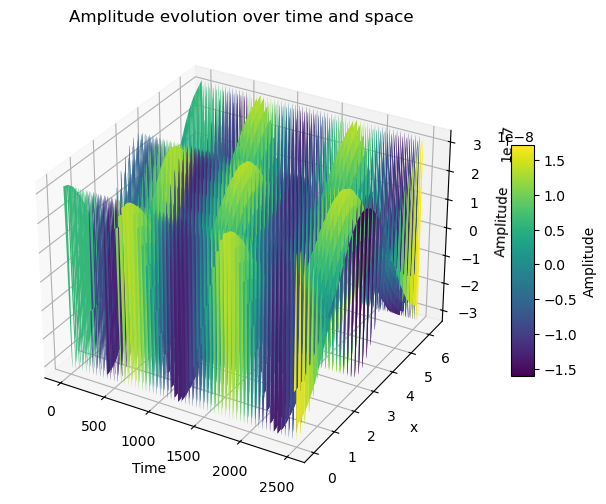

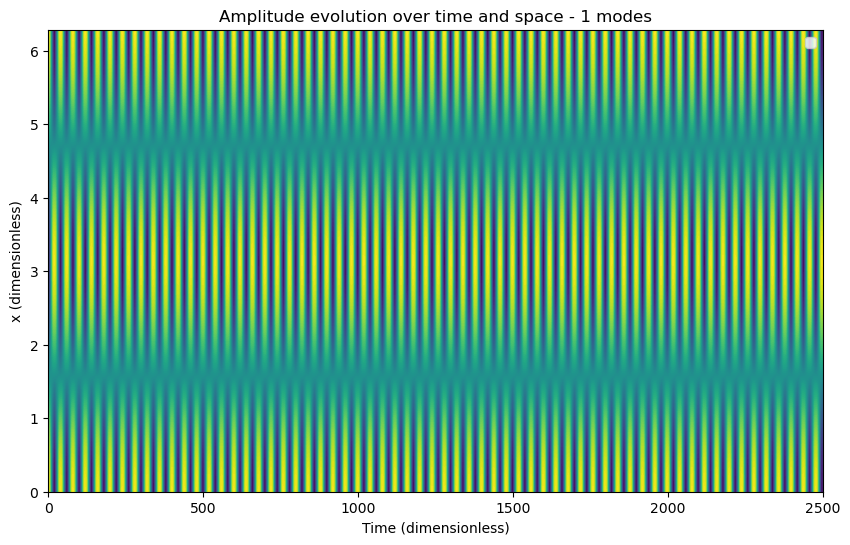

In [ ]:
from scipy.interpolate import interp1d

def extrapolate(x, y, x0):
    f = interp1d(x, y, fill_value="extrapolate")
    return f(x0)

amplitudes = []
x = np.linspace(0, 2*np.pi, 2*N)
for i in range(len(T)):
    t = T[i]
    val = extrapolate(Y[i, :N], Y[i, N:2*N], x)
    amplitudes.append(val)
amplitudes = np.array(amplitudes)

X, TT = np.meshgrid(x, T)

# 3D surface plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(TT, X, amplitudes, cmap='viridis', linewidth=0, antialiased=True)

ax.set_xlabel('Time')
ax.set_ylabel('x')
ax.set_zlabel('Amplitude')
ax.set_title('Amplitude evolution over time and space')

fig.colorbar(surf, shrink=0.5, aspect=10, label='Amplitude')
# plt.show()


print(amplitudes[0].shape)
plt.figure(figsize=(10,6))
plt.contourf(T, x, amplitudes.T, levels=100, cmap='viridis')
# plt.plot(T, amplitudes, label=f"Amplitude at r={2*np.pi - 0.2:.2f} L")
plt.xlabel("Time (dimensionless)")
plt.ylabel("x (dimensionless)")
plt.title(f"Amplitude evolution over time and space - {modes} modes")
plt.legend()

Text(0.5, 1.0, 'Amplitude at a fixed position over time - 1 modes')

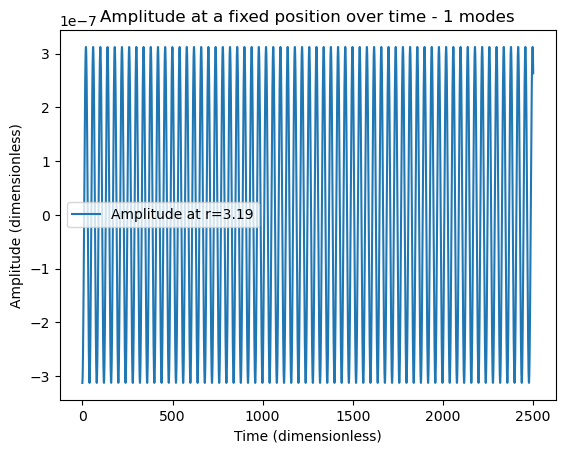

In [ ]:
plt.figure()
plt.plot(T, amplitudes[:, 32], label=f"Amplitude at r={x[32]:.2f}")
plt.xlabel("Time (dimensionless)")
plt.ylabel("Amplitude (dimensionless)")
plt.legend()
plt.title(f"Amplitude at a fixed position over time - {modes} modes")

100%|██████████| 1095/1095 [00:41<00:00, 26.10it/s]


ValueError: x and y must have same first dimension, but have shapes (55,) and (1095,)

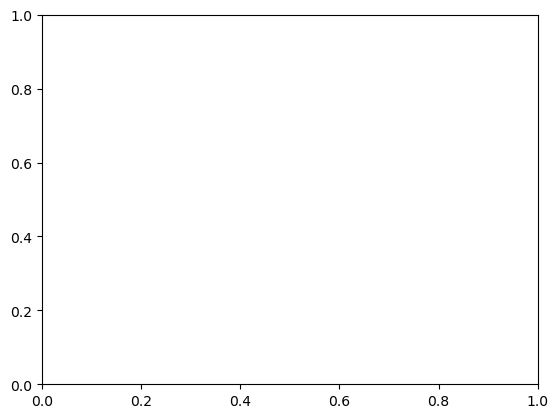

In [ ]:
import tqdm


t = 11
max_real_pos = []
for t in tqdm.tqdm(range(T.shape[0])):
    res, J = simManager.calculate_jacobian(Y[t, :N], Y[t, N:2*N], Y[t, 2*N:3*N], L, 145, 0, depth)
    eigvals = np.linalg.eigvals(J)
    max_real_pos.append(np.max(eigvals.real))

plt.plot(T, max_real_pos, label="Max real part of eigenvalues")

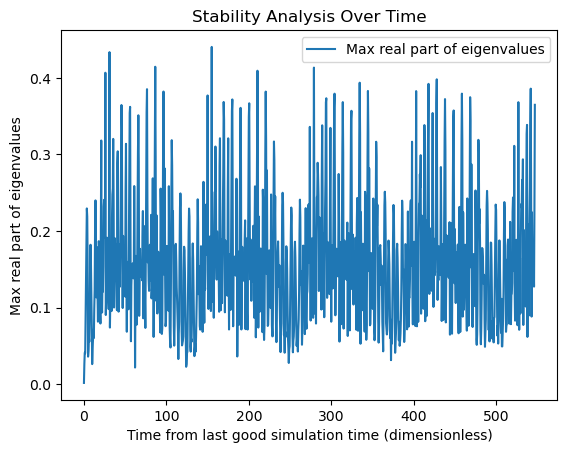

In [ ]:

plt.plot(T, max_real_pos, label="Max real part of eigenvalues")
plt.xlabel("Time from last good simulation time (dimensionless)")
plt.ylabel("Max real part of eigenvalues")
plt.legend()
plt.title("Stability Analysis Over Time")
plt.show()

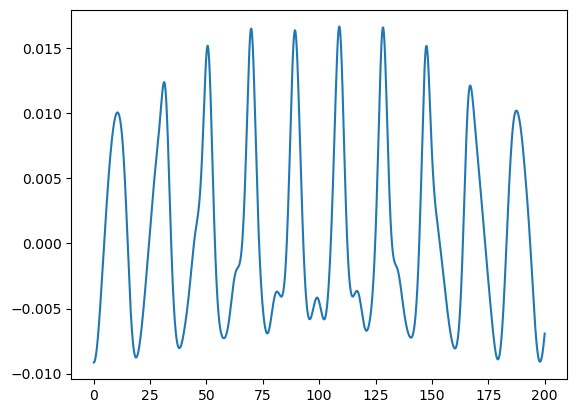

In [ ]:
plt.plot(T, Y[:, N+ N//2+10], label=f"Amplitude at r={r0:.2e} m")

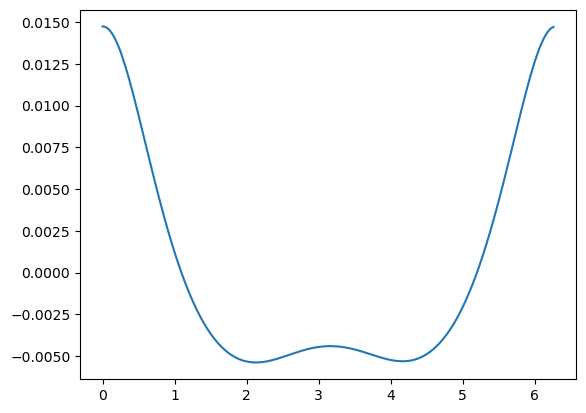

In [ ]:
plt.plot(r, Y[1250, N:2*N], label="Initial amplitude")

In [ ]:
filename = r"data\simulation_wl_1.00e-06m.h5"
from scipy.signal import find_peaks


with h5py.File(filename, "r") as file:
    T = file["T"][:]
    Y = file["Y"][:]
    Y0 = file["Y0"][:]

# plot the oscillation at a fixed position
r0 = r[N//2+10]
peaks, _ = find_peaks(Y[:, N+ N//2+10], height=0)

print(peaks.shape)


plt.figure()
plt.plot(T*_t0, Y[:, N+ N//2+10], label=f"Amplitude at r={r0:.2e} m from file")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (dimensionless)")
plt.title(f"{len(peaks)} oscillations in a single simulation")

plt.legend()
plt.show()

(0,)


(283,)


In [ ]:

%matplotlib Qt

In [ ]:
from matplotlib.animation import FuncAnimation
N = 32
fig, ax = plt.subplots()

line, = ax.plot([], [], lw=2)

def init():
    ax.set_xlim(Y[0, 0], Y[0, N-1])
    ax.set_ylim(Y[:, N:2*N].min(), Y[:, N:2*N].max())
    return line,

def update(frame):
    line.set_data(Y[frame, :N], Y[frame, N:2*N])
    return line,

ani = FuncAnimation(fig, update, frames=len(T), init_func=init, blit=True)
plt.show()